In [1]:
from hcipy import *
from hcipy import atmosphere
from hcipy import fourier
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# convenient conversion stuff
def seeing_to_r_o(seeing, lam_seeing=500):
    as_factor = 1/206265
    r_o = (0.98*lam_seeing*1e-9) / (as_factor*seeing)
    return r_o

def ro_to_seeing(r_o, lamda=500):
    seeing_rad = 0.98*lamda*1e-9/r_o
    factor_as = 60*60*180/(np.pi) 
    factor = 206265
    return seeing_rad*factor

def phase_to_WFE(phase, wave):
    mean = np.mean(phase)*wave/(2*np.pi)
    return np.sqrt(np.mean((phase*wave/(2*np.pi) - mean)**2))

def phase_to_WFE_std(phase, wave):
    return np.std(phase*wave/(2*np.pi))

def ro_to_variance(r_o, Dtel, lam_ro, lam_wave):
    ro_scaled = r_o * (lam_wave / lam_ro)**(6/5)
    var = 1.03*(Dtel/ro_scaled)**(5/3)
    return var

def variance_to_ro(var, Dtel, lam_ro, lam_wave):
    # note variance should be in radians
    ro_scaled = Dtel*(1.03/var)**(3/5)
    r_o = ro_scaled * (lam_ro / lam_wave)**(6/5)
    return r_o

def err_rad_to_nm(err_rad, lam):
    err_nm = lam*err_rad / (2*np.pi)
    return err_nm

def err_nm_to_rad(err_nm, lam):
    err_rad = err_nm*(2*np.pi) / lam
    return err_rad

## Unmod PWFS
These cells define the sysem for us.

In [3]:
wavelength = 800.0e-9
Dtel = 6.5
Dgrid = 60/56 * Dtel
n_bin = 2 #this allows us to oversample our pupil
grid = make_pupil_grid(60*n_bin, Dgrid) # could suepersample this to stop aliasing errors
wfs_grid = make_pupil_grid(120*n_bin, 2 * Dgrid)

In [18]:
pwfs = PyramidWavefrontSensorOptics(grid, wfs_grid, separation=Dgrid, pupil_diameter=Dtel, wavelength_0=wavelength, q=4) # q gives pixels per lambda over D
camera = NoiselessDetector(wfs_grid)
mpwfs = ModulatedPyramidWavefrontSensorOptics(pwfs, 3 * wavelength/Dtel, num_steps=20) #, fast_modulation_method=True) # had to exlude bc not on sebastiaans version

In [5]:
aperture = evaluate_supersampled(make_magellan_aperture(), grid, 8) # anti aliasing filter => softens filter
wf = Wavefront(aperture, wavelength)
wf.total_power = 1.0

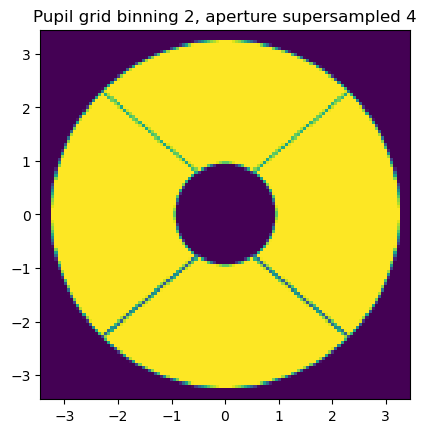

In [6]:
plt.figure()
plt.title(f"Pupil grid binning {n_bin}, aperture supersampled 4")
imshow_field(aperture)

In [7]:
zmodes = make_zernike_basis(200, Dtel, grid, 2)
dm = DeformableMirror(zmodes)

In [8]:
ff = FourierFilter(grid, make_circular_aperture(2 * np.pi * 50 / Dtel), q=4)

## Make interaction matrix

In [10]:
# Illumination reference
Iref = 0
for wfi in mpwfs(wf):
	Iref += wfi.power
Iref /= 20
Iref_bin = subsample_field(Iref, n_bin)

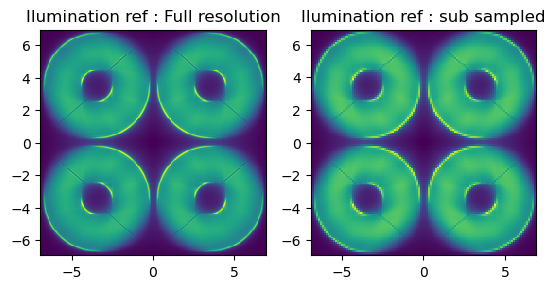

In [11]:
#showing the Reference
plt.subplot(1,2,1)
plt.title("Ilumination ref : Full resolution")
imshow_field(Iref)
plt.subplot(1,2,2)
plt.title("Ilumination ref : sub sampled")
imshow_field(Iref_bin)
plt.show()

In [12]:
#### SLOPES 
# Right now, working without regularizations
# Slopes are an tranversed slopes
calibration_amplitude = 10e-9
dm.flatten()

slopes = []
for i in range(dm.num_actuators):
	if i % 10 == 0:
		print("Calibrating mode {:d}".format(i))

	slope = 0
	for s in [-1, 1]:
		dm.actuators[i] += s * calibration_amplitude

		im = 0		
		for wfi in mpwfs(dm(wf)):
			im += wfi.power
		im /=20
		im_binned = subsample_field(im, n_bin)

		slope += s * im_binned / (2 * calibration_amplitude)

		dm.actuators[i] -= s * calibration_amplitude
	slopes.append(slope)
# slopes to use, tranverse of images
slopes = np.array(slopes).T
# reconstruction matrix from inverse tikhonov
reconstruction_matrix = inverse_tikhonov(slopes,1e-3)

Calibrating mode 0
Calibrating mode 10
Calibrating mode 20
Calibrating mode 30
Calibrating mode 40
Calibrating mode 50
Calibrating mode 60
Calibrating mode 70
Calibrating mode 80
Calibrating mode 90
Calibrating mode 100
Calibrating mode 110
Calibrating mode 120
Calibrating mode 130
Calibrating mode 140
Calibrating mode 150
Calibrating mode 160
Calibrating mode 170
Calibrating mode 180
Calibrating mode 190


## Make unmodulated optics

In [42]:
# Illumination reference
camera.integrate(pwfs.forward(wf), 1)
Iref_um = camera.read_out()
Iref_um /= Iref_um.sum()
Iref_um_bin = subsample_field(Iref_um, n_bin)

In [43]:
#### UNMODULATED SLOPES 
# Right now, working without regularizations
# Slopes are an tranversed slopes
calibration_amplitude = 10e-9
dm.flatten()

slopes_um = []
for i in range(dm.num_actuators):
	if i % 10 == 0:
		print("Calibrating mode {:d}".format(i))

	slope = 0
	for s in [-1, 1]:
		dm.actuators[i] += s * calibration_amplitude

		wfs_wf = pwfs(dm(wf))
		camera.integrate(wfs_wf, 1)
		im = camera.read_out()
		im /= np.sum(im)
		im_binned = subsample_field(im, n_bin)

		slope += s * im_binned / (2 * calibration_amplitude)

		dm.actuators[i] -= s * calibration_amplitude
	slopes_um.append(slope)
# slopes to use, tranverse of images
slopes_um = np.array(slopes).T

Calibrating mode 0
Calibrating mode 10
Calibrating mode 20
Calibrating mode 30
Calibrating mode 40
Calibrating mode 50
Calibrating mode 60
Calibrating mode 70
Calibrating mode 80
Calibrating mode 90
Calibrating mode 100
Calibrating mode 110
Calibrating mode 120
Calibrating mode 130
Calibrating mode 140
Calibrating mode 150
Calibrating mode 160
Calibrating mode 170
Calibrating mode 180
Calibrating mode 190


In [71]:
reconstruction_matrix = inverse_tikhonov(slopes_um, 1e-3)

# Sim 0: Basic response matrix

In [13]:
### MODES
# amplitude range
mode_index = np.array([0, 40 , 180]) #changed these from 41 and 181
amplitudes = np.linspace(0, 400e-9, 40)

In [72]:
#### UNMODULATED  COEFFICIENTS
dl_coef_UMOD = np.zeros((mode_index.size, amplitudes.size))
dl_coef_UMOD_rec = np.zeros((mode_index.size, amplitudes.size))
#iter
for k, mi in enumerate(mode_index):
	for ai, amp in enumerate(amplitudes):
		dm.flatten()
		dm.actuators[mi] = amp
		# INTERACTION MATRIX
		wfs_wf = pwfs(dm(wf))
		camera.integrate(wfs_wf, 1)
		im = camera.read_out().astype('float')
		im /= np.sum(im)
		im_binned = subsample_field(im, n_bin)
		#direct reconstruction:
		dl_coef_UMOD[k, ai] = slopes_um.dot( im_binned - Iref_um_bin )[mi] / np.linalg.norm(slopes_um[:,mi])**2
		dl_coef_UMOD_rec[k, ai] = reconstruction_matrix.T.dot(im_binned - Iref_um_bin)[mi]

In [36]:
#### MODULATED COEFFICIENTS
dl_coef = np.zeros((mode_index.size, amplitudes.size))
for k, mi in enumerate(mode_index):
	for ai, amp in enumerate(amplitudes):
		dm.flatten()
		dm.actuators[mi] = amp

		im = 0
		for wfi in mpwfs(dm(wf)):
			im += wfi.power
		im /= 20
		im_binned = subsample_field(im, n_bin)

		#direct reconstruction:
		dl_coef[k, ai] = slopes.T.dot( im_binned - Iref_bin )[mi] / np.linalg.norm(slopes[:,mi])**2

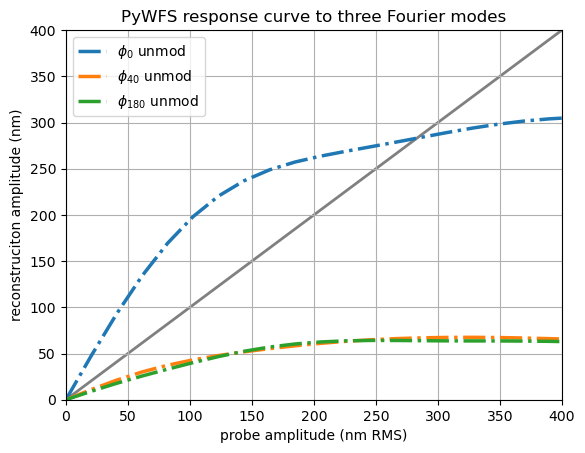

In [80]:
# PAPER PLOT
amplitudes_wfe = 2*amplitudes # translateing from dm surface units to wfe units

# for the three fourier modes
for i in range(3):
	# solid: modulated
	#plt.plot(amplitudes_wfe/1e-9, 2*dl_coef[i, :] / 1e-9, color='C{:d}'.format(i), ls='-', label=f'$\phi_{{{mode_index[i]:d}}}$ mod', lw=2.5)
	# dashed: unmodulated
	#plt.plot(amplitudes_wfe/1e-9, dl_coef_UMOD[i, :], color='C{:d}'.format(i), ls ='dotted', label=f'$\phi_{{{mode_index[i]:d}}}$ unmod', lw=2.5)
	plt.plot(amplitudes_wfe/1e-9, dl_coef_UMOD_rec[i, :]/1e-9, color='C{:d}'.format(i), ls ='-.', label=f'$\phi_{{{mode_index[i]:d}}}$ unmod', lw=2.5)
# plotting the average line
plt.plot(amplitudes_wfe/1e-9, amplitudes_wfe / 1e-9, color='gray', zorder=-1, lw=2)
# Labeling things
plt.title(f"PyWFS response curve to three Fourier modes")
plt.xlabel("probe amplitude (nm RMS)")
plt.ylabel("reconstruciton amplitude (nm)")
plt.ylim([0,400])
plt.xlim([0,400])
plt.legend()
plt.grid()

plt.savefig('../plots/OG_WFE_modes_unmod_only.png',dpi=300)

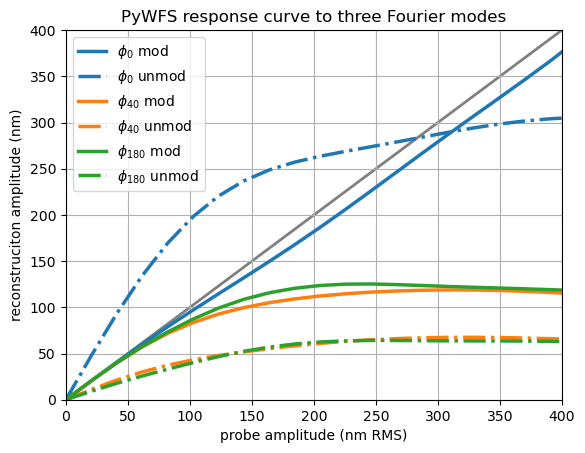

In [82]:
# PAPER PLOT
amplitudes_wfe = 2*amplitudes # translateing from dm surface units to wfe units

# for the three fourier modes
for i in range(3):
	# solid: modulated
	plt.plot(amplitudes_wfe/1e-9, 2*dl_coef[i, :] / 1e-9, color='C{:d}'.format(i), ls='-', label=f'$\phi_{{{mode_index[i]:d}}}$ mod', lw=2.5)
	# dashed: unmodulated
	plt.plot(amplitudes_wfe/1e-9, dl_coef_UMOD_rec[i, :]/1e-9, color='C{:d}'.format(i), ls ='-.', label=f'$\phi_{{{mode_index[i]:d}}}$ unmod', lw=2.5)

# plotting the average line
plt.plot(amplitudes_wfe/1e-9, amplitudes_wfe / 1e-9, color='gray', zorder=-1, lw=2)
# Labeling things
plt.title(f"PyWFS response curve to three Fourier modes")
plt.xlabel("probe amplitude (nm RMS)")
plt.ylabel("reconstruciton amplitude (nm)")
plt.ylim([0,400])
plt.xlim([0,400])
plt.legend()
plt.grid()

plt.savefig('../plots/OG_WFE_modes_unmod_zoom.png',dpi=300)

## Sim 1: Response matrix

In [12]:
### MODES
# amplitude range
mode_index = np.array([0, 40 , 180]) #changed these from 41 and 181
amplitudes = np.linspace(0, 400e-9, 20)

In [13]:
#### ABBERRATED COEFFICIENTS
num_iterations = 3
coef = np.zeros((mode_index.size, amplitudes.size, num_iterations))
wfe_res = 40e-9

for k, mi in enumerate(mode_index):
	for ai, amp in enumerate(amplitudes):
		for i in range(num_iterations):
			dm.flatten()
			dm.actuators[mi] = amp

			# Generating a power law surface aberration
			sa = SurfaceAberration(grid, wavelength, Dtel, exponent=-11/3)
			sa.surface_sag = sa.surface_sag - 0.98 * np.real(ff.forward(sa.surface_sag + 0j))
			sa.surface_sag *= wfe_res / np.std(sa.surface_sag[aperture>0])

			#wf_pwfs = pwfs(sa(dm(wf)))
			im = 0
			for wfi in mpwfs(sa(dm((wf)))):
				im += wfi.power
			im /= 20
			im_binned = subsample_field(im, n_bin)

			#coef[k, ai, i] = reconstruction_matrix.dot( im - Iref )[mi]
			#direct reconstructions:
			coef[k, ai, i] = slopes.T.dot( im_binned - Iref_bin )[mi] / np.linalg.norm(slopes[:,mi])**2


/opt/conda/lib/python3.10/site-packages/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


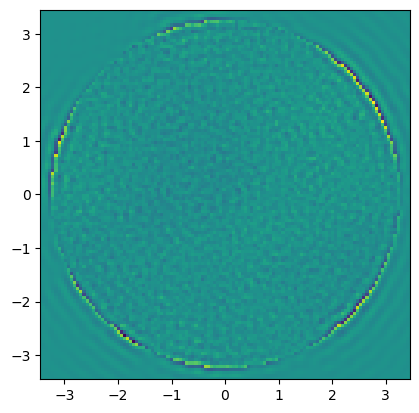

In [24]:
imshow_field(sa.phase(wavelength))

In [29]:
#phase = phase_to_WFE(sa.phase(wavelength)[aperture>0], wavelength)
WFE_sim_rad = err_nm_to_rad(wfe_res*2, 800e-9)
variance_to_ro(WFE_sim_rad, 6.5, 500e-9, 800e-9)

4.974664440064339

In [50]:
##### Generating phase screens
trials = 10
phase_screens = []
r_o = 0.10 # what is this in dimm...
# how do I translate this to WFE?

for i in range(10):
    layers = atmosphere.make_las_campanas_atmospheric_layers(grid, r0=r_o)
    ml_atmsph = atmosphere.MultiLayerAtmosphere(layers)
    phase = ml_atmsph.phase_for(wavelength)
    phase_screens.append(phase)


In [51]:
### Coefficients for LCO ABBERRATED COEFFICIENTS
num_iterations = trials
coef_LCO = np.zeros((mode_index.size, amplitudes.size, num_iterations))
wfe_res = 40e-9

for k, mi in enumerate(mode_index):
	for ai, amp in enumerate(amplitudes):
		for i in range(num_iterations):
			dm.flatten()
			dm.actuators[mi] = amp

			# pulling pre-computed phase screens
			phase = phase_screens[i]
			
			phase_res = phase - 0.98 * np.real(ff.forward(phase + 0j)) # HP filter
			#phase_res *= wfe_res / np.std(phase_res[aperture>0])
			abr = PhaseApodizer(phase_res*aperture)
			im = 0
			for wfi in mpwfs(abr(dm((wf)))):
				im += wfi.power
			im /= 20
			im_binned = subsample_field(im, n_bin)

			#coef[k, ai, i] = reconstruction_matrix.dot( im - Iref )[mi]
			#direct reconstructions:
			coef_LCO[k, ai, i] = slopes.T.dot( im_binned - Iref_bin )[mi] / np.linalg.norm(slopes[:,mi])**2


In [46]:
# uhh, can I get an RMS from this?
print("r_o: ", r_o)
print("DIMM: ", ro_to_seeing(r_o))
print("WFE: ",  phase_to_WFE(abr.phase[aperture>0], wavelength) )

r_o:  0.05
DIMM:  2.0213970000000003
WFE:  1.3429314985812551e-07


In [23]:
sa2 = SurfaceAberration(grid, wavelength, Dtel, exponent=-2.5)
sa2_f = sa2.surface_sag - 0.98 * np.real(ff.forward(sa2.surface_sag + 0j))
sa2_f *= wfe_res / np.std(sa2_f[aperture>0])

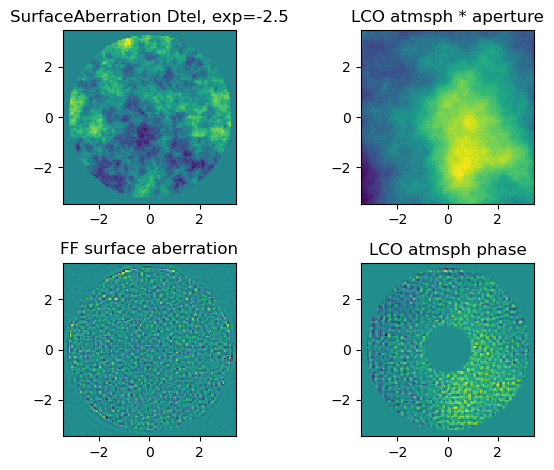

In [24]:
# checking LCO against power law
# might need to ork on supersamping
fig, axs = plt.subplots(nrows=2, ncols=2)

plt.sca(axs[0,0]) 
plt.title("SurfaceAberration Dtel, exp=-2.5")
imshow_field(sa2.surface_sag)

plt.sca(axs[1,0]) 
plt.title("FF surface aberration")
imshow_field(sa2_f)

plt.sca(axs[0,1]) 
plt.title("LCO atmsph * aperture")
imshow_field(phase)

plt.sca(axs[1,1])  
plt.title("LCO atmsph phase")
imshow_field(phase_res*aperture)

plt.tight_layout()
plt.show()

In [25]:
#### PURE COEFFICIENTS

dl_coef = np.zeros((mode_index.size, amplitudes.size))
for k, mi in enumerate(mode_index):
	for ai, amp in enumerate(amplitudes):
		dm.flatten()
		dm.actuators[mi] = amp

		im = 0
		for wfi in mpwfs(dm(wf)):
			im += wfi.power
		im /= 20
		im_binned = subsample_field(im, n_bin)

		#recondstruction matrix
		#dl_coef[k, ai] = reconstruction_matrix.dot( im - Iref )[mi]
		#direct reconstruction:
		dl_coef[k, ai] = slopes.T.dot( im_binned - Iref_bin )[mi] / np.linalg.norm(slopes[:,mi])**2

Residual WFE 80 nm


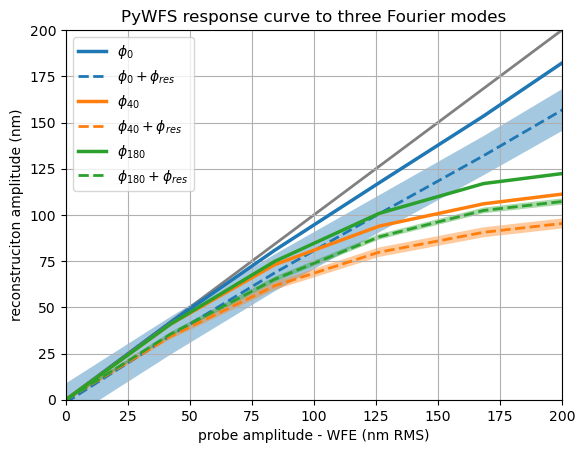

In [52]:
# PAPER PLOT

#plt.axvline(2*calibration_amplitude/1e-9, label = 'calib amp', color = 'red')
amplitudes_wfe = 2*amplitudes # translateing from dm surface units to wfe units
for i in range(3):
	mean = 2*np.mean(coef_LCO, axis=2)[i] / 1e-9
	std = 2*np.std(coef_LCO, axis=2)[i] / 1e-9
	# dashed: average mode with errors
	plt.fill_between(amplitudes_wfe/1e-9, mean - std, mean + std, color='C{:d}'.format(i), alpha=0.4, lw=0)
	plt.plot(amplitudes_wfe/1e-9, 2*dl_coef[i, :] / 1e-9, color='C{:d}'.format(i), ls='-', label=f'$\phi_{{{mode_index[i]:d}}}$', lw=2.5)
	plt.plot(amplitudes_wfe/1e-9, mean, lw=2, color='C{:d}'.format(i), ls ='--', label=f'$\phi_{{{mode_index[i]:d}}} + \phi_{{res}}$')
	# solid: default
	
# plotting the average line
plt.plot(amplitudes_wfe/1e-9, amplitudes_wfe / 1e-9, color='gray', zorder=-1, lw=2)
plt.title(f"PyWFS response curve to three Fourier modes")
print(f"Residual WFE {(2*wfe_res/1e-9):0.0f} nm")
plt.xlabel("probe amplitude - WFE (nm RMS)")
plt.ylabel("reconstruciton amplitude (nm)")
plt.ylim([0,200])
plt.xlim([0,200])
plt.legend()
plt.grid()

plt.savefig('../plots/OG_WFE_modes_zoom.png',dpi=300)

Residual WFE 80 nm


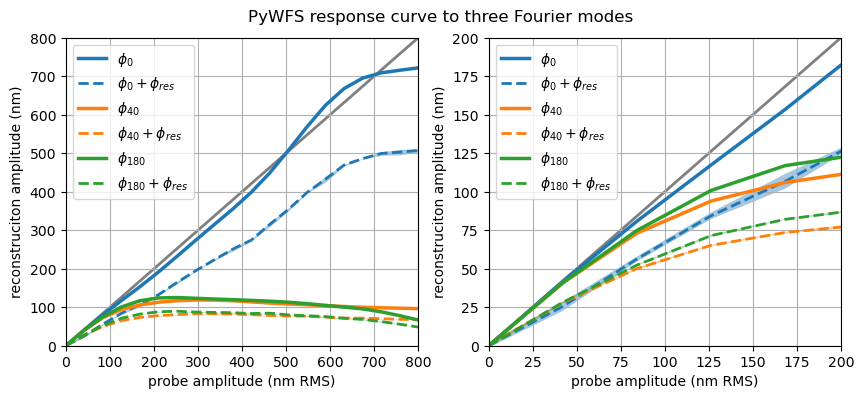

In [65]:
# PAPER PLOT - 2
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4), facecolor='white')

amplitudes_wfe = 2*amplitudes # translateing from dm surface units to wfe units
print(f"Residual WFE {(2*wfe_res/1e-9):0.0f} nm")

# SUBPLOT 1 - same as above
plt.suptitle(f"PyWFS response curve to three Fourier modes", y = 0.95)
axs[0].set_xlabel("probe amplitude (nm RMS)")
axs[0].set_ylabel("reconstruciton amplitude (nm)")

for i in range(3):
	mean = 2*np.mean(coef, axis=2)[i] / 1e-9
	std = 2*np.std(coef, axis=2)[i] / 1e-9
	# solid: default
	axs[0].plot(amplitudes_wfe/1e-9, 2*dl_coef[i, :] / 1e-9, color='C{:d}'.format(i), ls='-', label=f'$\phi_{{{mode_index[i]:d}}}$', lw=2.5)
	# dashed: average mode with errors
	axs[0].plot(amplitudes_wfe/1e-9, mean, lw=2, color='C{:d}'.format(i), ls ='--', label=f'$\phi_{{{mode_index[i]:d}}} + \phi_{{res}}$')
	axs[0].fill_between(amplitudes_wfe/1e-9, mean - std, mean + std, color='C{:d}'.format(i), alpha=0.4, lw=0)
# plotting the average line
axs[0].plot(amplitudes_wfe/1e-9, amplitudes_wfe / 1e-9, color='gray', zorder=-1, lw=2)
axs[0].set_ylim([0,800])
axs[0].set_xlim([0,800])
axs[0].legend()
axs[0].grid()

# SUBPLOT 2 - first 100nm  WFE
axs[1].set_xlabel("probe amplitude (nm RMS)")
axs[1].set_ylabel("reconstruciton amplitude (nm)")

for i in range(3):
	mean = 2*np.mean(coef, axis=2)[i] / 1e-9
	std = 2*np.std(coef, axis=2)[i] / 1e-9
	# solid: default
	axs[1].plot(amplitudes_wfe/1e-9, 2*dl_coef[i, :] / 1e-9, color='C{:d}'.format(i), ls='-', label=f'$\phi_{{{mode_index[i]:d}}}$', lw=2.5)
	# dashed: average mode with errors
	axs[1].plot(amplitudes_wfe/1e-9, mean, lw=2, color='C{:d}'.format(i), ls ='--', label=f'$\phi_{{{mode_index[i]:d}}} + \phi_{{res}}$')
	axs[1].fill_between(amplitudes_wfe/1e-9, mean - std, mean + std, color='C{:d}'.format(i), alpha=0.4, lw=0)
# plotting the average line
axs[1].plot(amplitudes_wfe/1e-9, amplitudes_wfe / 1e-9, color='gray', zorder=-1, lw=2)
axs[1].set_ylim([0,200])
axs[1].set_xlim([0,200])
axs[1].legend()
axs[1].grid()

plt.savefig('../plots/OG_WFE_modes_zoom.png',dpi=300)

### Trying trucation

This is attempting the same plot as the paper, but now truncating.

In [23]:
reconstruction_matrix = inverse_tikhonov(slopes,1e-2)

In [24]:
#### TRUNCATED - ABBERRATED COEFFICIENTS
num_iterations = 3
trnc_coef = np.zeros((mode_index.size, amplitudes.size, num_iterations))
wfe_res = 40e-9

for k, mi in enumerate(mode_index):
	for ai, amp in enumerate(amplitudes):
		for i in range(num_iterations):
			dm.flatten()
			dm.actuators[mi] = amp

			sa = SurfaceAberration(grid, wavelength, Dtel, exponent=-2.5)
			sa.surface_sag = sa.surface_sag - 0.98 * np.real(ff.forward(sa.surface_sag + 0j))
			sa.surface_sag *= wfe_res / np.std(sa.surface_sag[aperture>0])

			#wf_pwfs = pwfs(sa(dm(wf)))
			im = 0
			for wfi in mpwfs(sa(dm((wf)))):
				im += wfi.power
			im /= 20
			im_binned = subsample_field(im, n_bin)

			#coef[k, ai, i] = reconstruction_matrix.dot( im - Iref )[mi]
			#direct reconstructions:
			trnc_coef[k, ai, i] = reconstruction_matrix.dot( im_binned - Iref_bin )[mi]

In [25]:
#### TRUNC PURE COEFFICIENTS
trnc_dl_coef = np.zeros((mode_index.size, amplitudes.size))

for k, mi in enumerate(mode_index):
	for ai, amp in enumerate(amplitudes):
		dm.flatten()
		dm.actuators[mi] = amp

		im = 0
		for wfi in mpwfs(dm(wf)):
			im += wfi.power
		im /= 20
		im_binned = subsample_field(im, n_bin)

		#recondstruction matrix
		#dl_coef[k, ai] = reconstruction_matrix.dot( im - Iref )[mi]
		#direct reconstruction:
		trnc_dl_coef[k, ai] = reconstruction_matrix.dot( im_binned - Iref_bin )[mi] 

Residual WFE 80 nm


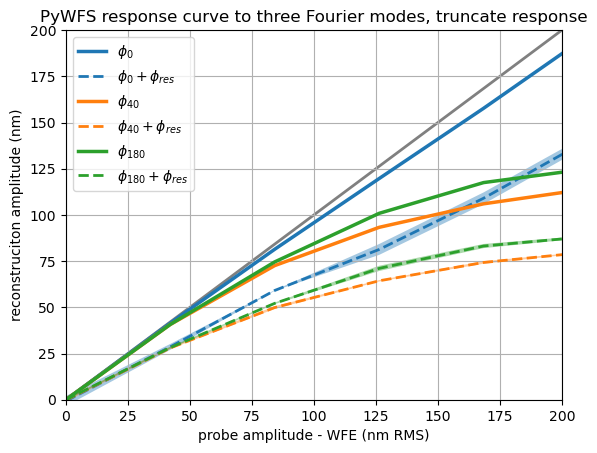

In [26]:
# Trunc - PAPER PLOT

#plt.axvline(2*calibration_amplitude/1e-9, label = 'calib amp', color = 'red')
amplitudes_wfe = 2*amplitudes # translateing from dm surface units to wfe units
for i in range(3):
	mean = 2*np.mean(trnc_coef, axis=2)[i] / 1e-9
	std = 2*np.std(trnc_coef, axis=2)[i] / 1e-9
	# dashed: average mode with errors
	plt.fill_between(amplitudes_wfe/1e-9, mean - std, mean + std, color='C{:d}'.format(i), alpha=0.4, lw=0)
	plt.plot(amplitudes_wfe/1e-9, 2*trnc_dl_coef[i, :] / 1e-9, color='C{:d}'.format(i), ls='-', label=f'$\phi_{{{mode_index[i]:d}}}$', lw=2.5)
	plt.plot(amplitudes_wfe/1e-9, mean, lw=2, color='C{:d}'.format(i), ls ='--', label=f'$\phi_{{{mode_index[i]:d}}} + \phi_{{res}}$')
	# solid: default
	
# plotting the average line
plt.plot(amplitudes_wfe/1e-9, amplitudes_wfe / 1e-9, color='gray', zorder=-1, lw=2)
plt.title(f"PyWFS response curve to three Fourier modes, truncate response")
print(f"Residual WFE {(2*wfe_res/1e-9):0.0f} nm")
plt.xlabel("probe amplitude - WFE (nm RMS)")
plt.ylabel("reconstruciton amplitude (nm)")
plt.ylim([0,200])
plt.xlim([0,200])
plt.legend()
plt.grid()

plt.savefig('../plots/OG_WFE_modes_zoom_trunc.png',dpi=300)

/tmp/ipykernel_1787714/3516596287.py:7: RuntimeWarning: divide by zero encountered in divide
  gain =  mean / (2*trnc_dl_coef[i, :])
/tmp/ipykernel_1787714/3516596287.py:8: RuntimeWarning: divide by zero encountered in divide
  gain_std = std / (2*trnc_dl_coef[i, :])
/tmp/ipykernel_1787714/3516596287.py:10: RuntimeWarning: invalid value encountered in add
  plt.fill_between(amps, gain - gain_std, gain + gain_std, color='C{:d}'.format(i), alpha=0.4, lw=0)


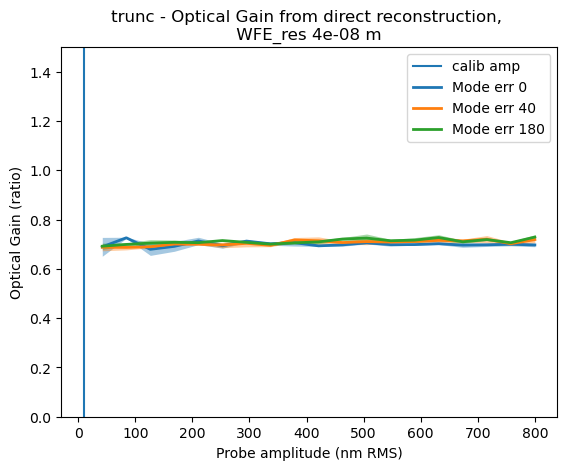

In [28]:
plt.axvline(calibration_amplitude/1e-9, label = 'calib amp')

for i in range(3):
	amps = 2*amplitudes/1e-9 # in WFE units, not DM surface
	mean = 2*np.mean(trnc_coef, axis=2)[i] 
	std = 2*np.std(trnc_coef, axis=2)[i]
	gain =  mean / (2*trnc_dl_coef[i, :])
	gain_std = std / (2*trnc_dl_coef[i, :])
	# dashed: average mode with errors
	plt.fill_between(amps, gain - gain_std, gain + gain_std, color='C{:d}'.format(i), alpha=0.4, lw=0)
	plt.plot(amps, gain, lw=2, color='C{:d}'.format(i),  label='Mode err {:d}'.format(mode_index[i]))
	# solid: default
	#plt.plot(amplitudes/1e-9, dl_coef[i, :] / 1e-9, color='C{:d}'.format(i), ls='-', label='Mode {:d}'.format(mode_index[i]), lw=2.5)
# plotting the average line
plt.title(f"trunc - Optical Gain from direct reconstruction, \n WFE_res {wfe_res} m ")
plt.xlabel("Probe amplitude (nm RMS)")
plt.ylabel("Optical Gain (ratio)")
plt.ylim([0, 1.5])
plt.legend()
plt.show()

### Is OG flat?

Checking that the OG values follow the same line

/tmp/ipykernel_1957336/3770928048.py:8: RuntimeWarning: divide by zero encountered in divide
  gain =  mean / (2*dl_coef[i, :])
/tmp/ipykernel_1957336/3770928048.py:9: RuntimeWarning: divide by zero encountered in divide
  gain_std = std / (2*dl_coef[i, :])
/tmp/ipykernel_1957336/3770928048.py:11: RuntimeWarning: invalid value encountered in add
  plt.fill_between(amps, gain - gain_std, gain + gain_std, color='C{:d}'.format(i), alpha=0.4, lw=0)


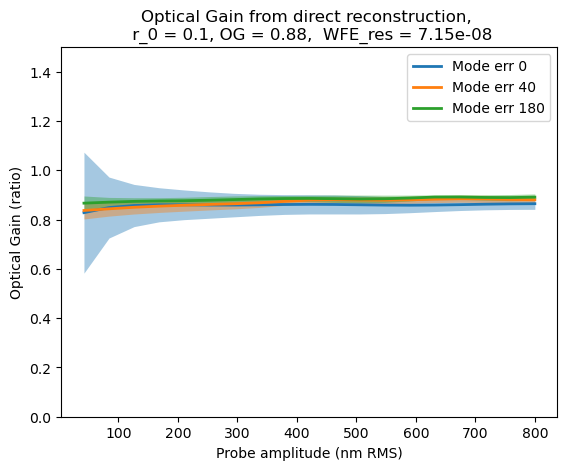

In [53]:
# optical gain by ratio
#plt.axvline(calibration_amplitude/1e-9, label = 'calib amp')

for i in range(3):
	amps = 2*amplitudes/1e-9 # in WFE units, not DM surface
	mean = 2*np.mean(coef_LCO, axis=2)[i] 
	std = 2*np.std(coef_LCO, axis=2)[i]
	gain =  mean / (2*dl_coef[i, :])
	gain_std = std / (2*dl_coef[i, :])
	# dashed: average mode with errors
	plt.fill_between(amps, gain - gain_std, gain + gain_std, color='C{:d}'.format(i), alpha=0.4, lw=0)
	plt.plot(amps, gain, lw=2, color='C{:d}'.format(i),  label='Mode err {:d}'.format(mode_index[i]))
	# solid: default
	#plt.plot(amplitudes/1e-9, dl_coef[i, :] / 1e-9, color='C{:d}'.format(i), ls='-', label='Mode {:d}'.format(mode_index[i]), lw=2.5)
# plotting the average line
plt.title(f"Optical Gain from direct reconstruction, \n r_0 = {r_o}, OG = {np.mean(gain[np.isfinite(gain)]):.2f},  WFE_res = {phase_to_WFE(abr.phase[aperture>0], wavelength):.2e}")
plt.xlabel("Probe amplitude (nm RMS)")
plt.ylabel("Optical Gain (ratio)")
plt.ylim([0, 1.5])
plt.legend()
plt.show()

In [39]:
np.mean(gain[np.isfinite(gain)])

0.9168592442611365

# Sim 2: iterate over the residual WFE

In [37]:
# optical gain by residual
num_iterations = 20
residuals = np.linspace(0, 200e-9, 25)
WFE_coef = np.zeros((mode_index.size, residuals.size, num_iterations))
test_amp = 10e-9

for k, mi in enumerate(mode_index):
	for ri, res in enumerate(residuals):
		for i in range(num_iterations):
			dm.flatten()
			dm.actuators[mi] = test_amp

			sa = SurfaceAberration(grid, wavelength, Dtel, exponent=-2.5)
			sa.surface_sag = sa.surface_sag - 0.98 * np.real(ff.forward(sa.surface_sag + 0j))
			sa.surface_sag *= res / np.std(sa.surface_sag[aperture>0]) # in wfe??

			#wf_pwfs = pwfs(sa(dm(wf)))
			im = 0
			for wfi in mpwfs(sa(dm((wf)))):
				im += wfi.power
			im /= 20
			im_binned = subsample_field(im, n_bin)
			#direct reconstruction:
			WFE_coef[k, ri, i] = slopes.T.dot( im_binned - Iref_bin )[mi] / np.linalg.norm(slopes[:,mi])**2

In [38]:
# calculate streh
residuals_wfe = 2*residuals
strehl = np.exp(-(2*np.pi*residuals_wfe/wavelength)**2)

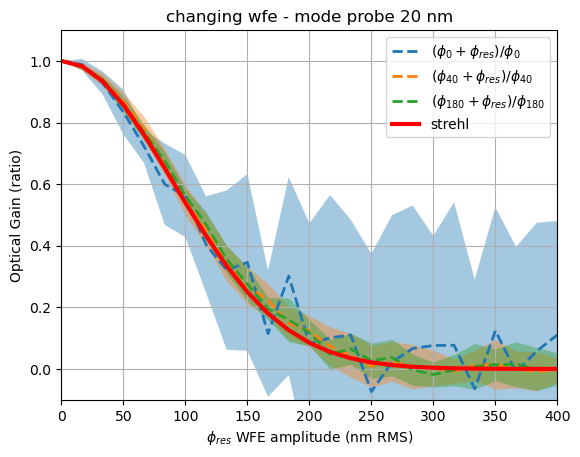

In [39]:
for i in range(3):
	mean = np.mean(WFE_coef, axis=2)[i] 
	std = np.std(WFE_coef, axis=2)[i] 
	gain = mean / test_amp
	std_gain = std/test_amp
	# dashed: average mode with errors
	plt.fill_between(residuals_wfe/1e-9, gain - std_gain, gain + std_gain, color='C{:d}'.format(i), alpha=0.4, lw=0)
	plt.plot(residuals_wfe/1e-9, gain, lw=2, color='C{:d}'.format(i), ls ='--', label=f'$(\phi_{{{mode_index[i]:d}}} + \phi_{{res}}) / \phi_{{{mode_index[i]:d}}} $')
	# solid: default
	#plt.plot(amplitudes/1e-9, dl_coef[i, :] / 1e-9, color='C{:d}'.format(i), ls='-', label='Mode {:d}'.format(mode_index[i]), lw=2.5)
# plotting the average line
#plt.plot(residuals/1e-9, residuals/1e-9, color='gray', zorder=-1, lw=2)
plt.plot(residuals_wfe/1e-9, strehl, color = 'red', label='strehl', lw = 3)
plt.title(f"changing wfe - mode probe {(2*test_amp/1e-9):0.0f} nm")
plt.xlabel(f'$\phi_{{res}}$ WFE amplitude (nm RMS)')
plt.ylabel("Optical Gain (ratio)")
plt.xlim(0, 400)
plt.ylim(-0.1, 1.1)
plt.legend()
plt.grid()
plt.savefig('../plots/OG_prove_wfe_SR.png',dpi=300)

In [ ]:
# could replot with OG vs. strehl  > line

## Iter over all the modes at one poke WFE


In [31]:
# OG by MODE
num_iterations = 20
residuals_test = np.array([0, 10e-9, 25e-9, 50e-9, 100e-9, 200e-9])
modes_tested = np.arange(0, 200, 10)
modes_iter_coef = np.zeros((residuals_test.size, modes_tested.size, num_iterations))
test_amp = 10e-9

for ri, res in enumerate(residuals_test):
	for k, mi in enumerate(modes_tested):
		for i in range(num_iterations):
			dm.flatten()
			dm.actuators[mi] = test_amp

			sa = SurfaceAberration(grid, wavelength, Dtel, exponent=-2.5)
			sa.surface_sag = sa.surface_sag - 0.98 * np.real(ff.forward(sa.surface_sag + 0j))
			sa.surface_sag *= res / np.std(sa.surface_sag[aperture>0]) # in wfe??

			#wf_pwfs = pwfs(sa(dm(wf)))
			im = 0
			for wfi in mpwfs(sa(dm((wf)))):
				im += wfi.power
			im /= 20
			im_binned = subsample_field(im, n_bin)
			#direct reconstruction:
			modes_iter_coef[ri, k, i] = slopes.T.dot( im_binned - Iref_bin )[mi] / np.linalg.norm(slopes[:,mi])**2

/opt/conda/lib/python3.10/site-packages/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


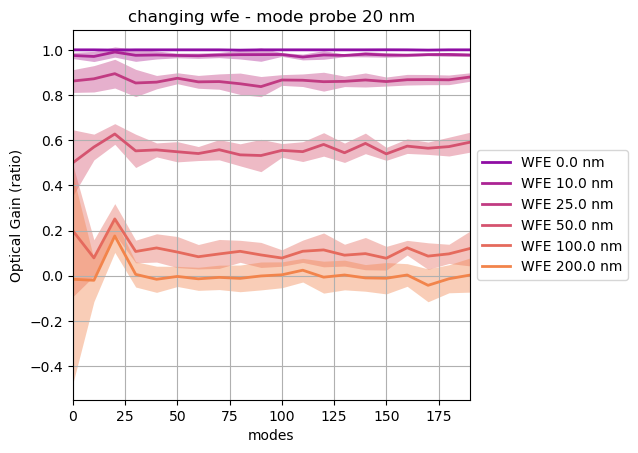

In [32]:
# plot: jsut the Mode to OG value
fig = plt.figure()
ax = plt.subplot(111)
colors = plt.cm.plasma(np.linspace(0.3,.7, len(residuals_test)))

for i in range(len(residuals_test)):
	mean = np.mean(modes_iter_coef, axis=2)[i] 
	std = np.std(modes_iter_coef, axis=2)[i] 
	gain = mean / test_amp
	std_gain = std / test_amp
	# dashed: average mode with errors
	ax.fill_between(modes_tested, gain - std_gain, gain + std_gain,  alpha=0.4, lw=0, color=colors[i])
	ax.plot(modes_tested, gain, lw=2, ls ='-', label=f'WFE {residuals_test[i]/1e-9 :0.4} nm',  c=colors[i])
	# solid: default
	
# plotting the average line
plt.title(f"changing wfe - mode probe {(2*test_amp/1e-9):0.0f} nm")
plt.xlabel("modes")
plt.ylabel("Optical Gain (ratio)")
plt.legend()
plt.xlim(0,190)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()
plt.savefig('../plots/OG_vs_modes',dpi=300)

#### Combine the last two plots for the paper

In [34]:
residuals_test = np.array([0, 10e-9, 25e-9, 50e-9, 100e-9, 200e-9])

# calculate streh
residuals = np.linspace(0, 200e-9, 25)
residuals_wfe = 2*residuals
strehl = np.exp(-(2*np.pi*residuals_wfe/wavelength)**2)

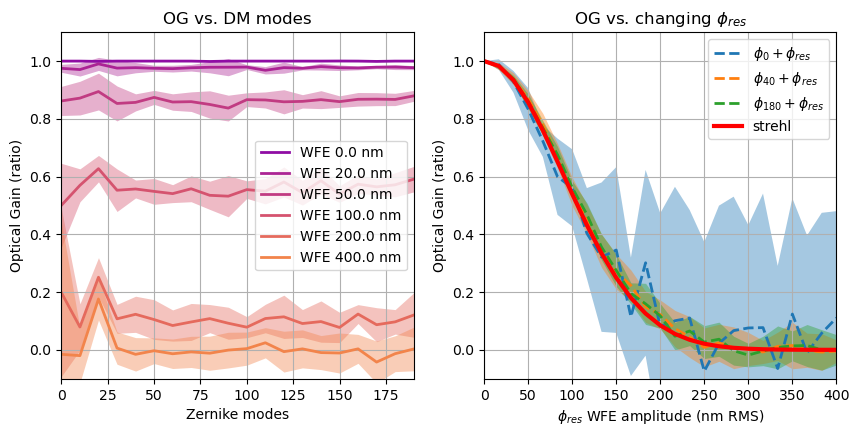

In [40]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4.5), facecolor='white')

colors = plt.cm.plasma(np.linspace(0.3,.7, len(residuals_test)))

# SUBPLOT 1: Showing flat residuals across modes
axs[0].set_title(f"OG vs. DM modes")
axs[0].set_xlabel("Zernike modes")
axs[0].set_ylabel("Optical Gain (ratio)")
#plot for each resifual
for i in range(len(residuals_test)):
	mean = np.mean(modes_iter_coef, axis=2)[i] 
	std = np.std(modes_iter_coef, axis=2)[i] 
	gain = mean / test_amp
	std_gain = std/test_amp
	# dashed: average mode with errors
	axs[0].fill_between(modes_tested, gain - std_gain, gain + std_gain, color=colors[i], alpha=0.4, lw=0)
	axs[0].plot(modes_tested, gain, lw=2, c=colors[i], label=f'WFE {2*residuals_test[i]/1e-9 :0.4} nm')
	# solid: default
axs[0].set_xlim(0, 190)
axs[0].set_ylim(-0.1, 1.1)
axs[0].legend()
axs[0].grid()

# SUBPLOT 2: Showing the relationship to strehl
for i in range(3):
	mean = np.mean(WFE_coef, axis=2)[i] 
	std = np.std(WFE_coef, axis=2)[i] 
	gain = mean / test_amp
	std_gain = std/test_amp
	# dashed: average mode with errors
	axs[1].fill_between(residuals_wfe/1e-9, gain - std_gain, gain + std_gain, color='C{:d}'.format(i), alpha=0.4, lw=0)
	axs[1].plot(residuals_wfe/1e-9, gain, lw=2, color='C{:d}'.format(i), ls ='--', label=f'$\phi_{{{mode_index[i]:d}}} + \phi_{{res}}$')

axs[1].plot(residuals_wfe/1e-9, strehl, color = 'red', label='strehl', lw = 3)
axs[1].set_title(f"OG vs. changing $\phi_{{res}}$")
axs[1].set_xlabel(f"$\phi_{{res}}$ WFE amplitude (nm RMS)")
axs[1].set_ylabel("Optical Gain (ratio)")
axs[1].set_xlim(0, 400)
axs[1].set_ylim(-0.1, 1.1)
axs[1].legend()
axs[1].grid()


plt.savefig('../plots/OG_vs_mode_vs_SR.png',dpi=300)

## LCO turbulence
Retrying the last plot but now iter over turbulence. 

In [59]:
# I need to generate the turbulence screens beforehand. 
##### Generating phase screens
num_iterations = 20
r_o_test = np.array([0.20, 0.15, 0.12, 0.1, 0.08, 0.05])
modes_tested = np.arange(0, 200, 10)
test_amp = 10e-9
phase_screens_og = []
# how do I translate this to WFE?

for ri, r0 in enumerate(r_o_test):
	phase_tmp = []
	for i in range(num_iterations):
		layers = atmosphere.make_las_campanas_atmospheric_layers(grid, r0=r0)
		ml_atmsph = atmosphere.MultiLayerAtmosphere(layers)
		phase = ml_atmsph.phase_for(wavelength)
		phase_tmp.append(phase)
	phase_screens_og.append(phase_tmp)

In [61]:
# OG by MODE
# 9.18.2024 - redoing previous plots with chosen R-o values
modes_iter_r0 = np.zeros((r_o_test.size, modes_tested.size, num_iterations))
for ri, r0 in enumerate(r_o_test):
	for k, mi in enumerate(modes_tested):
		for i in range(num_iterations):
			dm.flatten()
			dm.actuators[mi] = test_amp

			phase = phase_screens_og[ri][i]
			phase_res = phase - 0.98 * np.real(ff.forward(phase + 0j)) # HP filter

			abr = PhaseApodizer(phase_res*aperture)
			im = 0
			for wfi in mpwfs(abr(dm((wf)))):
				im += wfi.power
			im /= 20
			im_binned = subsample_field(im, n_bin)
			#direct reconstruction:
			modes_iter_r0[ri, k, i] = slopes.T.dot( im_binned - Iref_bin )[mi] / np.linalg.norm(slopes[:,mi])**2
	print("finished ro: ", r0)

finished ro:  0.2
finished ro:  0.15
finished ro:  0.12
finished ro:  0.1
finished ro:  0.08
finished ro:  0.05


In [ ]:
# plot: jsut the Mode to OG value
fig = plt.figure()
ax = plt.subplot(111)
colors = plt.cm.plasma(np.linspace(0.3,.7, len(r_o_test)))

for i in range(len(r_o_test)):
	mean = np.mean(modes_iter_coef, axis=2)[i] 
	std = np.std(modes_iter_coef, axis=2)[i] 
	gain = mean / test_amp
	std_gain = std / test_amp
	# dashed: average mode with errors
	ax.fill_between(modes_tested, gain - std_gain, gain + std_gain,  alpha=0.4, lw=0, color=colors[i])
	ax.plot(modes_tested, gain, lw=2, ls ='-', label=f'r_o {r_o_test[i]/1e-9 :0.4} nm',  c=colors[i])
	# solid: default
	
# plotting the average line
plt.title(f"changing wfe - mode probe {(2*test_amp/1e-9):0.0f} nm")
plt.xlabel("modes")
plt.ylabel("Optical Gain (ratio)")
plt.legend()
plt.xlim(0,190)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()
plt.savefig('../plots/OG_vs_modes',dpi=300)

In [ ]:
# for the next plot, I have to keep track of WFE and pake sure to log it per image

### SelfRM spoof

Checking all the calibration values

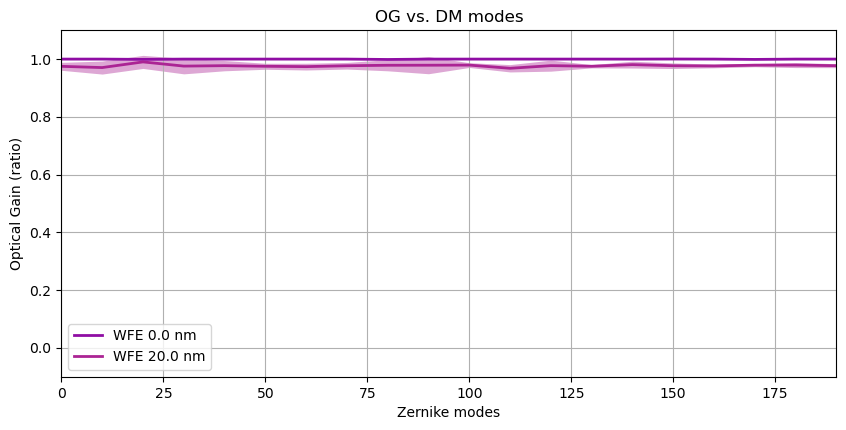

In [44]:
## checking our lab cal amplitudes (like a selfRM)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,4.5), facecolor='white')

colors = plt.cm.plasma(np.linspace(0.3,.7, len(residuals_test)))

# SUBPLOT 1: Showing flat residuals across modes
axs.set_title(f"OG vs. DM modes")
axs.set_xlabel("Zernike modes")
axs.set_ylabel("Optical Gain (ratio)")
#plot for each resifual
for i in range(2):
	mean = np.mean(modes_iter_coef, axis=2)[i] 
	std = np.std(modes_iter_coef, axis=2)[i] 
	gain = mean / test_amp
	std_gain = std/test_amp
	# dashed: average mode with errors
	axs.fill_between(modes_tested, gain - std_gain, gain + std_gain, color=colors[i], alpha=0.4, lw=0)
	axs.plot(modes_tested, gain, lw=2, c=colors[i], label=f'WFE {2*residuals_test[i]/1e-9 :0.4} nm')
	# solid: default
axs.set_xlim(0, 190)
axs.set_ylim(-0.1, 1.1)
axs.legend()
axs.grid()

## Trucate:  OG vs. Modes

Doing the same thing as before, now truncated

In [1]:
# OG by MODE
modes_tested = np.arange(0, 200, 1)
test_amp = 10e-9

# the non truncated system
modes_coef = np.zeros((modes_tested.size))

for k, mi in enumerate(modes_tested):
    dm.flatten()
    dm.actuators[mi] = test_amp

    im = 0
    for wfi in mpwfs(dm(wf)):
        im += wfi.power
    im /= 20
    im_binned = subsample_field(im, n_bin)

    #direct reconstruction:
    modes_coef[k] = slopes.T.dot( im_binned - Iref_bin )[mi] / np.linalg.norm(slopes[:,mi])**2

NameError: name 'dm' is not defined

In [50]:
reconstruction_matrix = inverse_tikhonov(slopes,1e-1)

In [51]:
#### TRUNC PURE COEFFICIENTS
reconstruction_matrix = inverse_tikhonov(slopes,1e-1)

trnc_modes_coef = np.zeros((modes_tested.size))

for k, mi in enumerate(modes_tested):
    dm.flatten()
    dm.actuators[mi] = test_amp

    im = 0
    for wfi in mpwfs(dm(wf)):
        im += wfi.power
    im /= 20
    im_binned = subsample_field(im, n_bin)

    #recondstruction matrix
    #dl_coef[k, ai] = reconstruction_matrix.dot( im - Iref )[mi]
    #direct reconstruction:
    trnc_modes_coef[k] = reconstruction_matrix.dot( im_binned - Iref_bin )[mi] 

In [53]:
#### TRUNC PURE COEFFICIENTS
reconstruction_matrix = inverse_tikhonov(slopes,5e-2)

trnc_modes_coef_05 = np.zeros((modes_tested.size))

for k, mi in enumerate(modes_tested):
    dm.flatten()
    dm.actuators[mi] = test_amp

    im = 0
    for wfi in mpwfs(dm(wf)):
        im += wfi.power
    im /= 20
    im_binned = subsample_field(im, n_bin)

    #recondstruction matrix
    #dl_coef[k, ai] = reconstruction_matrix.dot( im - Iref )[mi]
    #direct reconstruction:
    trnc_modes_coef_05[k] = reconstruction_matrix.dot( im_binned - Iref_bin )[mi] 

In [56]:
#### TRUNC PURE COEFFICIENTS
reconstruction_matrix = inverse_tikhonov(slopes,1e-2)

trnc_modes_coef_01 = np.zeros((modes_tested.size))

for k, mi in enumerate(modes_tested):
    dm.flatten()
    dm.actuators[mi] = test_amp

    im = 0
    for wfi in mpwfs(dm(wf)):
        im += wfi.power
    im /= 20
    im_binned = subsample_field(im, n_bin)

    #recondstruction matrix
    #dl_coef[k, ai] = reconstruction_matrix.dot( im - Iref )[mi]
    #direct reconstruction:
    trnc_modes_coef_01[k] = reconstruction_matrix.dot( im_binned - Iref_bin )[mi] 

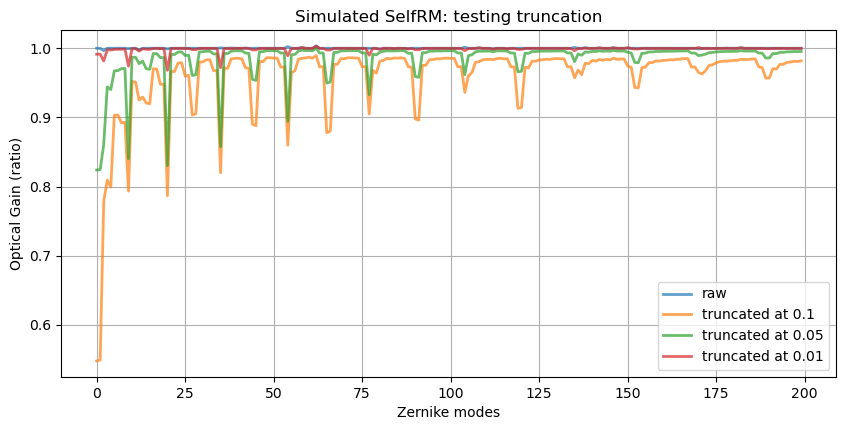

In [60]:
## checking our lab cal amplitudes (like a selfRM)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,4.5), facecolor='white')

colors = plt.cm.plasma(np.linspace(0.3,.7, len(residuals_test)))

# SUBPLOT 1: Showing flat residuals across modes
axs.set_title(f"Simulated SelfRM: testing truncation")
axs.set_xlabel("Zernike modes")
axs.set_ylabel("Optical Gain (ratio)")

# dashed: average mode with errors
axs.plot(modes_tested, modes_coef/test_amp, lw=2, label="raw", alpha=0.7)
axs.plot(modes_tested, trnc_modes_coef/test_amp, lw=2, label="truncated at 0.1", alpha=0.7)
axs.plot(modes_tested, trnc_modes_coef_05/test_amp, lw=2, label="truncated at 0.05", alpha=0.7)
axs.plot(modes_tested, trnc_modes_coef_01/test_amp, lw=2, label="truncated at 0.01", alpha=0.7)

#solid: default
#axs.set_xlim(0, 190)
#axs.set_ylim(-0.1, 1.1)
axs.legend()
axs.grid()

#### These will divide out
Now will show a simulated on sky selfRM will divide out


In [62]:
#### TRUNCATED - ABBERRATED COEFFICIENTS
num_iterations = 10
wfe_res = 20e-9

trnc_modes_dl_coef_05 = np.zeros((modes_tested.size, num_iterations))

reconstruction_matrix = inverse_tikhonov(slopes,5e-2)

for k, mi in enumerate(modes_tested):
	for i in range(num_iterations):
		dm.flatten()
		dm.actuators[mi] = test_amp

		sa = SurfaceAberration(grid, wavelength, Dtel, exponent=-2.5)
		sa.surface_sag = sa.surface_sag - 0.98 * np.real(ff.forward(sa.surface_sag + 0j))
		sa.surface_sag *= wfe_res / np.std(sa.surface_sag[aperture>0])

		#wf_pwfs = pwfs(sa(dm(wf)))
		im = 0
		for wfi in mpwfs(sa(dm((wf)))):
			im += wfi.power
		im /= 20
		im_binned = subsample_field(im, n_bin)

		#direct reconstructions:
		trnc_modes_dl_coef_05[k, i] = reconstruction_matrix.dot( im_binned - Iref_bin )[mi]

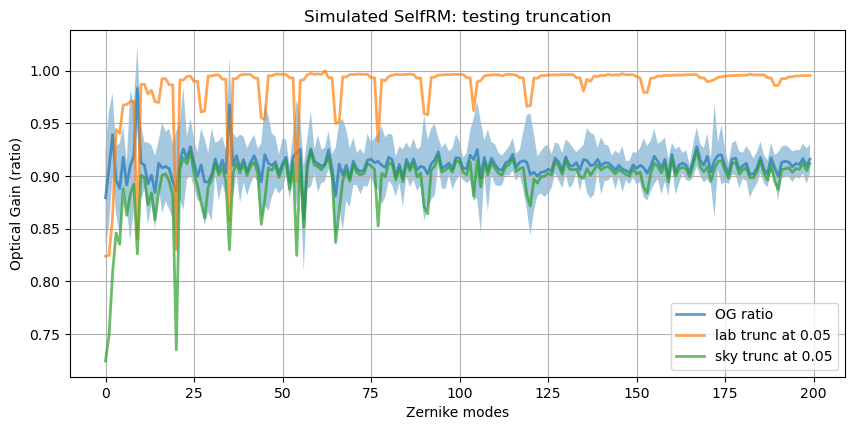

In [76]:
## checking our lab cal amplitudes (like a selfRM)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,4.5), facecolor='white')

colors = plt.cm.plasma(np.linspace(0.3,.7, len(residuals_test)))

# SUBPLOT 1: Showing flat residuals across modes
axs.set_title(f"Simulated SelfRM: testing truncation")
axs.set_xlabel("Zernike modes")
axs.set_ylabel("Optical Gain (ratio)")

mean = np.mean(trnc_modes_dl_coef_05, axis=1)
std = np.std(trnc_modes_dl_coef_05, axis=1)
gain = mean / trnc_modes_coef_05
std_gain = std / test_amp


axs.fill_between(modes_tested, gain - std_gain, gain + std_gain, alpha=0.4, lw=0)
axs.plot(modes_tested, gain, lw=2, label="OG ratio", alpha=0.7)

# dashed: average mode with errors
axs.plot(modes_tested, trnc_modes_coef_05/test_amp, lw=2, label="lab trunc at 0.05", alpha=0.7)
axs.plot(modes_tested, mean/test_amp, lw=2, label="sky trunc at 0.05", alpha=0.7)


axs.legend()
axs.grid()

In [74]:
std_gain.shape

(200,)